# CS109B Final Project
# Greek vases

* Andrew Lee
* Diego Zertuche
* Javiera Astudillo

# Motivation, context & framing of the problem

## Introduction
The study of ancient greek art facilitates the understanding of Greek society. Within its forms, pottery stands out due to its durability, its historical coverage and the vast amount of available samples. The extensive amount of vases obstructs their study due to the time consumption of the collection of relevant samples for a given research topic. It seems desirable to come up with some automatic object detection system for vase selection. In this work we focus on the detection of shields in vase images. Initially, we aim to detect the presence of shields within vase images. If this turns out successful, we will move on one step further to detect the location of the shield within the image.

## Image classification and segmentation
Image classification and segmentation has greatly developed in the last couple of years with multiple applications on medical imaging analysis, object detection, recognition tasks, traffic control systems within others [1]. Currently, Deep Learning techniques models lead as the state-of-the-art models in the field [2]. Here, we describe a few, though it's not a comprehensive overview of all existing techniques but just a brief listing of some of them.

The first image classification breakthrough of this century came in 2012 with Alexnet [9], which reached an accuracy of 15.3% on ImageNet dataset, more than 10.8 percentage points lower than runner-up. It implemented multiple convolution layers, alternating with max pooling layers and ReLu activations. After that, multiple models came up that extended Alexnet work such as VGG [10], Inception [11], Resnet [12] and MobileNet [13].

Object recognition models share similar components as image classifications models, such as CNN layers, and extend them further, incorporating encoder and decoder parts, skip-connections and multi-scale analysis. A couple of prominent works include [3] U-Net, [4] DeepLab and [5] Mask R-CNN. U-Net improved its predecessor's resolution representations by creating information streams between high and low-resolution sections; DeepLab introduced a dilation rate that enabled enlarging the receptive field at no extra computational cost; Mask R-CNN incorporates bounding box candidates which improves traditional region proposal methods. 

## AI and ML for artworks
Different museums and artwork centres have expressed interest in developing automatic analysis of their pieces. For instance, in 2019 the Metropolitan Museum of Art in New York uploaded a challenge to Kaggle for the recognition of artwork attributes within their collection. Multiple works have addressed object detection within artworks such as [6], [7] and [8].They relied either on CNN feature extractors or more specifically in Image Segmentation models. They are all closely related to our setting, though they are mostly applied to paintings, all with well-delimited boundaries. In the current setting, greek vases present an additional challenge imposed by the variable zoom and angle of the paintings within each vase image.


# Notebook Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import requests
import time
import json
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

from urllib.request import urlopen
from PIL import Image, ImageOps

from tqdm.auto import tqdm, trange

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Exploration & EDA

We first performed a general data exploration to see what were the characteristics of the metadata of the images and how easy/fast dividing the images based on particular characteristics would be. We first took a subset of the whole dataset and explored it.

In [ ]:
PATH = '/content/drive/MyDrive/CS109b FP'

DATA_PATH = f'{PATH}/data'
IMG_PATH = f'{DATA_PATH}/images'
META_PATH = f'{DATA_PATH}/dataset_v0_metadata.csv'

PAGES = 100
SLEEP_TIME = 0

# Make data and image folder if none
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
if not os.path.exists(IMG_PATH):
    os.mkdir(IMG_PATH)

We took the first 100 pages of the API and got the metadata and explored it. We noticed that the data had a `Decoration` column, where the vase image was explained lexically, and there was also data on the type of vase. We decided that we where going to explore all the images that had the word `Shield` and its variations in its Decoration. A label was created that indicated the presence of a shield and then the images of the data were taken from the URL provided in the metadata gathered from the API.

In [ ]:
 # get first few pages of the API
 webpages = []
 for page in trange(1, PAGES + 1):
     link = f"http://armsandarmor.orphe.us/api/items/?format=json&page={page}"
     r = requests.get(link)
     webpage = json.loads(r.text)
     webpages.append(webpage)
     time.sleep(SLEEP_TIME)

 all_pages = []
 for page in webpages:
     all_pages.extend(page['results'])

In [ ]:
 # convert data to df
 all_files = []
 for i in range(len(all_pages)):
     # extract metadata for vase i
     result = all_pages[i]
     id = result['id']
     data_dict = {'id': id}
     for item in result['metadata']:
         data_dict[item['label']] = item['value']

     # extract image urls for vase i
     # each vase can have multiple images
     for file in result['files']:
         this_file_data = data_dict.copy()
         this_file_data['image'] = file['filepath']
         all_files.append(this_file_data)

In [ ]:
df = pd.DataFrame(all_files)
 # Add Shield column. 1 indicates presence of a shield
df['Shield'] = np.where(df['Decoration'].str.contains('SHIELD'), 1, 0)

Error with image 113, removing from dataset.
Error with image 152, removing from dataset.
Error with image 153, removing from dataset.
Error with image 154, removing from dataset.
Error with image 155, removing from dataset.
Error with image 156, removing from dataset.
Error with image 157, removing from dataset.
Error with image 171, removing from dataset.
Error with image 172, removing from dataset.
Error with image 173, removing from dataset.
Error with image 174, removing from dataset.
Error with image 183, removing from dataset.
Error with image 184, removing from dataset.
Error with image 185, removing from dataset.
Error with image 186, removing from dataset.
Error with image 187, removing from dataset.
Error with image 188, removing from dataset.
Error with image 189, removing from dataset.
Error with image 192, removing from dataset.
Error with image 193, removing from dataset.
Error with image 245, removing from dataset.
Error with image 293, removing from dataset.
Error with

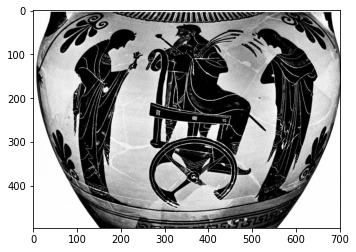

In [ ]:
# access images
raw_images = []
new_df = df.copy()

for i,url in enumerate(tqdm(new_df['image'])):
    try:
        img = Image.open(urlopen(url))
        raw_images.append(img)
    except:
        print(f"Error with image {i}, removing from dataset.")
        new_df = new_df.drop(i)
print("\n")
new_df = new_df.reset_index(drop=True)
plt.imshow(raw_images[0])

## Visualizing Some Images

We started to visualize the images gathered and we immediatly saw that the images that had `Shield` in its Decoration description often didn't have a visible shield in the image. This is because the Decoration description is made at a vase basis, so there are mutliple images of the vase with multiple angles and some of those angles don't include the shield in the image. This is a problem that we would need to address.

In [ ]:
# EDA
for i in range(5):
  raw_images[i]

## Example of Preprocessing

For the general preprocessing of the data, we decide to take the images which had different sizes and convert them to grayscale and resize them to 256 by 256 pixels. This provided more manageable images but they were still complex enough to be able to train model with them.

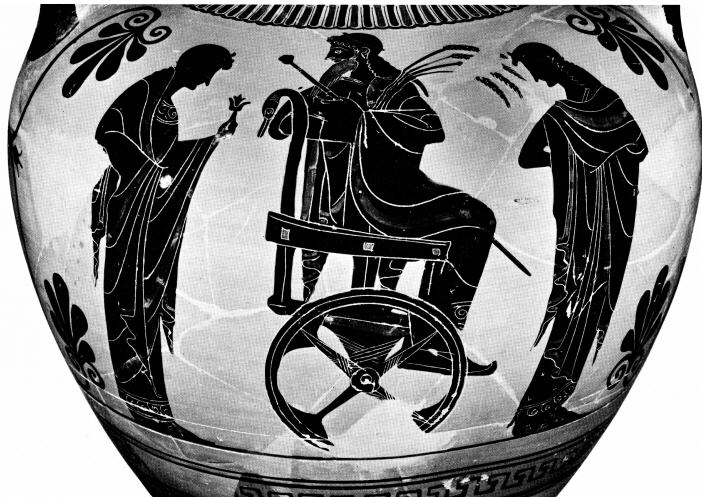

In [ ]:
ex = raw_images[0]
ex

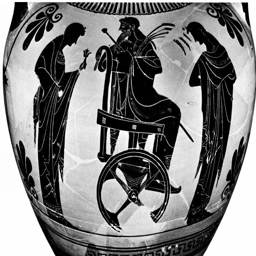

In [ ]:
ex = ex.resize((256,256))
ex

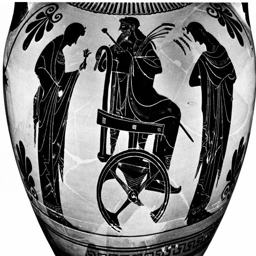

In [ ]:
ex = ImageOps.grayscale(ex)
ex

# Data Wrangling & Preprocessing

We now proceeded to take the metadata from all the images and start to gather all the images that had `Shield` in its Decoration. Unfortunately, there were not many vases (and images) that had shields, as from the almost 170,000 images only around 5,500 were labeled as having shields. The metadata of the images with shields were stored. 

In [ ]:
# Getting metadata of all images
webpages = []
for page in trange(1, 1157):
    link = f"http://armsandarmor.orphe.us/api/items/?format=json&page={page}"
    r = requests.get(link)
    webpage = json.loads(r.text)
    webpages.append(webpage)

all_pages = []
for page in webpages:
    all_pages.extend(page['results'])

In [ ]:
# convert data to df
all_files = []
for i in range(len(all_pages)):
    # extract metadata for vase i
    result = all_pages[i]
    id = result['id']
    data_dict = {'id': id}
    for item in result['metadata']:
        data_dict[item['label']] = item['value']

    # extract image urls for vase i
    # each vase can have multiple images
    for file in result['files']:
        this_file_data = data_dict.copy()
        this_file_data['image'] = file['filepath']
        all_files.append(this_file_data)

In [ ]:
# Adding label if Shield is in picture
df = pd.DataFrame(all_files)
df['Shield'] = df.Decoration.apply(lambda x: 1 if 'SHIELD' in str(x).split() or 'SHIELDS' in str(x).split() or 'SHIELDS,' in str(x).split() or 'SHIELD,' in str(x).split() else 0)
df.head()

,id,Source ID,Vase Number,Fabric,Technique,Shape Name,Date,Attributed To,Decoration,Publication Record,Pleiades URI,Color,Provenance,LIMC ID,LIMC Web,CAVI Collection,image,Transcription,TranscriptionTrimmed,Shield
0,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/mQxPdwYS...,NaN,NaN,0
1,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/PUxm6FWQ...,NaN,NaN,0
2,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/WzgM2ybZ...,NaN,NaN,0
3,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/ooPvVYEv...,NaN,NaN,0
4,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/3Lof9mrm...,NaN,NaN,0


In [ ]:
df.shape

(168277, 20)

In [ ]:
df.to_csv('/content/drive/MyDrive/CS109b FP/data/full_metadata.csv', index=False)
df_shields = df[df.Shield == 1]
df_shields.to_csv('/content/drive/MyDrive/CS109b FP/data/full_shields_metadata.csv', index=False)

In [ ]:
df_shields.shape # Total number of images with Shield

(6873, 20)

We also examined visually all of the types of shapes of vases and only selected the ones that could potentially give a clear view of the vase and the images. For example, there were plenty of type of shapes that were fragments of certain type of vases, and these often didn't give meaningful visual images, so the images that were not in the good types of shapes were removed. This gaves us around 3,500 images with shields and that were of the 'good type' of vases. Then the raw images were accessed and we applied the preprocessing steps explained before, and the metadata and images were stored.

In [ ]:
# We examined visiually all of the types of shapes and only selected the ones that give a clear view of the vase
good_types = ['AMPHORA, NECK', 'HYDRIA', 'AMPHORA A', 'LEKYTHOS', 'AMPHORA, NECK AND LID', 'CUP A','KRATER, CALYX','AMPHORA B',
'OINOCHOE', 'PANATHENAIC AMPHORA', 'KYATHOS','KRATER, BELL','KRATER, COLUMN','KRATER, VOLUTE','CUP B','CUP C',
 'LEKANIS','AMPHORA C','AMPHORA','STAMNOS','AMPHORA, PANATHENAIC SHAPE','MUG','KANTHAROS','LEBES','LEKYTHOS, SQUAT']

In [ ]:
df_shields = pd.read_csv('/content/drive/MyDrive/CS109b FP/data/full_shields_metadata.csv')
df_shields[df_shields['Shape Name'].isin(good_types)].shape # Reduced number of images with shield

(4896, 20)

Error with image 24, removing from dataset.
Error with image 25, removing from dataset.
Error with image 29, removing from dataset.
Error with image 30, removing from dataset.
Error with image 31, removing from dataset.
Error with image 32, removing from dataset.
Error with image 33, removing from dataset.
Error with image 34, removing from dataset.
Error with image 35, removing from dataset.
Error with image 38, removing from dataset.
Error with image 39, removing from dataset.
Error with image 43, removing from dataset.
Error with image 44, removing from dataset.
Error with image 79, removing from dataset.
Error with image 80, removing from dataset.
Error with image 81, removing from dataset.
Error with image 82, removing from dataset.
Error with image 83, removing from dataset.
Error with image 172, removing from dataset.
Error with image 173, removing from dataset.
Error with image 174, removing from dataset.
Error with image 175, removing from dataset.
Error with image 203, removi

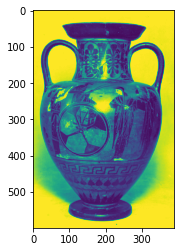

In [ ]:
# Access images that have shields and are in the good types
raw_images = []
new_df = df_shields[df_shields['Shape Name'].isin(good_types)].reset_index(drop=True)

for i,url in enumerate(tqdm(new_df['image'])):
    try:
        img = Image.open(urlopen(url))
        raw_images.append(img)
    except:
        print(f"Error with image {i}, removing from dataset.")
        new_df = new_df.drop(i)
print("\n")
new_df = new_df.reset_index(drop=True)
plt.imshow(raw_images[0])

In [ ]:
# Preprocessing the images
img_pre = []
for i, img in enumerate(tqdm(raw_images)):
    new = img.resize((256,256))
    new = ImageOps.grayscale(new)
    new = np.array(new)/255
    img_pre.append(new)

img_pre = np.array(img_pre)

In [ ]:
# Saving the images
for i, img in enumerate(tqdm(img_pre)):
    # THE IMAGES HAVE TO BE SAVED WITH UNORMALIZED VALUES, 
    # SO WE NEED TO APPLY NORMALIZATION EVERY TIME WE LOAD THEM AGAIN
    img = Image.fromarray(img*255)
    img = img.convert("L")
    img.save("/content/drive/MyDrive/CS109b FP/shield_images/shield_{}.jpeg".format(i))

In [ ]:
# Adding image file name to dataframe with metadata and saving
files = []
for i in range(len(img_pre)):
    files.append("shield_{}.jpeg".format(i))
new_df['File'] = files
new_df.head()
new_df.to_csv('/content/drive/MyDrive/CS109b FP/data/type_shields_metadata.csv', index=False)

## Getting Labeled Images from Labelbox



Given the problem that there were multiple images with different angles of the vases, we had to go through all the shield images manually and label the images that actually had a visible shield in the image. We used [Labelbox](https://labelbox.com/) for this task. We then downloaded the manually labeled data from Labelbox and loaded only the images that actually had the shields in the image and had around 1,800 images with shields. We took a random sample of the non-shield images that matched the size of our shield data, and this is how we created our working dataset for the classification model. We split the data in train and test partitions, taking into account the vase numbers, to ensure that different images from the same vase were not in the train and test set.

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/CS109b FP/data/type_shields_labeled_dirty.csv')
label_df.head()

,ID,DataRow ID,Labeled Data,Label,Created By,Project Name,Created At,Updated At,Seconds to Label,External ID,Agreement,Benchmark Agreement,Benchmark ID,Benchmark Reference ID,Dataset Name,Reviews,View Label,Has Open Issues
0,cko9g2dgw00023g68vuymuzka,cko9fusev1qa30yss10td8swf,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097238000,1620097278000,8.592,shield_469.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0
1,cko9g2giu00053g68omsgc8n5,cko9fusga1ufr0yssbb2y1zb5,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097242000,1620097278000,0.397,shield_1818.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0
2,cko9g2kxk00083g68l7n0iquz,cko9fusfq1snf0yss3sxe28yd,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097247000,1620097279000,7.239,shield_1238.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0
3,cko9g2qrd000b3g68y8mvx2qz,cko9fusex1qdn0yss08iwgsak,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097255000,1620097279081,9.161,shield_501.jpeg,NaN,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0
4,cko9g2u81000e3g68xqs11c97,cko9fusgb1ujb0yss43e83hgr,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097260000,1620097279431,2.912,shield_1850.jpeg,NaN,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0


In [ ]:
# The ones that have reviews are of 'lower quality' (i.e. they have shields but they're not completely visible or are in weird angles)
label_df = label_df[label_df.Reviews=='[]']
label_df.shape

(3583, 18)

In [ ]:
label_df['Shield'] = label_df.Label.apply(lambda x: int(json.loads(x)['classifications'][0]['answer'][0]['value']))
label_df.head()

,ID,DataRow ID,Labeled Data,Label,Created By,Project Name,Created At,Updated At,Seconds to Label,External ID,Agreement,Benchmark Agreement,Benchmark ID,Benchmark Reference ID,Dataset Name,Reviews,View Label,Has Open Issues,Shield
0,cko9g2dgw00023g68vuymuzka,cko9fusev1qa30yss10td8swf,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097238000,1620097278000,8.592,shield_469.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0,0
1,cko9g2giu00053g68omsgc8n5,cko9fusga1ufr0yssbb2y1zb5,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097242000,1620097278000,0.397,shield_1818.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0,1
2,cko9g2kxk00083g68l7n0iquz,cko9fusfq1snf0yss3sxe28yd,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097247000,1620097279000,7.239,shield_1238.jpeg,-1.0,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0,1
3,cko9g2qrd000b3g68y8mvx2qz,cko9fusex1qdn0yss08iwgsak,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097255000,1620097279081,9.161,shield_501.jpeg,NaN,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0,0
4,cko9g2u81000e3g68xqs11c97,cko9fusgb1ujb0yss43e83hgr,https://storage.labelbox.com/cko9dkb6x38ty0y7s...,"{""objects"":[],""classifications"":[{""featureId"":...",diego.zertuche@hotmail.com,AC209 B,1620097260000,1620097279431,2.912,shield_1850.jpeg,NaN,-1,NaN,NaN,Shield vases,[],https://editor.labelbox.com?project=cko9drr3b4...,0,0


In [ ]:
# Getting final dataset
files = label_df[label_df.Shield == 1]['External ID']
imgs = []
labels = []
for i, img in enumerate(tqdm(files)):
  new = Image.open('/content/drive/MyDrive/CS109b FP/shield_images/' + img)
  new = np.array(new)/255
  imgs.append(new)
  labels.append(1)

In [ ]:
# Getting metadata of final dataset
files = list(files)
meta = pd.read_csv('/content/drive/MyDrive/CS109b FP/data/type_shields_metadata.csv')
meta = meta[meta.File.isin(files)]
meta.head()

,id,Source ID,Vase Number,Fabric,Technique,Shape Name,Date,Attributed To,Decoration,Publication Record,Pleiades URI,Color,Provenance,LIMC ID,LIMC Web,CAVI Collection,image,Transcription,TranscriptionTrimmed,Shield,File
0,9341,{03DB8933-0874-41E0-BEF8-564EC375F060},4,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",NaN,MEDEA GROUP by UNKNOWN,B: WARRIOR AND CHARIOTEER IN CHARIOT (TURNING)...,"Bulletin du Musee Hongrois des Beaux-Arts, Bud...",None,White,NaN,1009.0,http://ark.dasch.swiss/ark:/72163/080e-73b1c12...,NaN,https://iiif-orpheus.s3.amazonaws.com/xsJsp4oP...,NaN,NaN,1,shield_0.jpeg
3,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571.0,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/SqTwjTEf...,"""7649\n","""7649\n",1,shield_3.jpeg
4,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571.0,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/L4P37Ge9...,"""7649\n","""7649\n",1,shield_4.jpeg
5,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571.0,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/VMSXJifj...,"""7649\n","""7649\n",1,shield_5.jpeg
6,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571.0,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/6nMhzPSy...,"""7649\n","""7649\n",1,shield_6.jpeg


In [ ]:
# Getting a random sample of non-shield images to have balanced dataset
full_df = pd.read_csv('/content/drive/MyDrive/CS109b FP/data/full_metadata.csv')
good_types = ['AMPHORA, NECK', 'HYDRIA', 'AMPHORA A', 'LEKYTHOS', 'AMPHORA, NECK AND LID', 'CUP A','KRATER, CALYX','AMPHORA B',
'OINOCHOE', 'PANATHENAIC AMPHORA', 'KYATHOS','KRATER, BELL','KRATER, COLUMN','KRATER, VOLUTE','CUP B','CUP C',
 'LEKANIS','AMPHORA C','AMPHORA','STAMNOS','AMPHORA, PANATHENAIC SHAPE','MUG','KANTHAROS','LEBES','LEKYTHOS, SQUAT']
full_df.head()
not_df = full_df[(full_df['Shape Name'].isin(good_types)) & (full_df.Shield==0) & 
                 (pd.isnull(full_df.Decoration)==False)].sample(n=len(imgs), replace=False, random_state=23).reset_index(drop=True)
not_df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,Source ID,Vase Number,Fabric,Technique,Shape Name,Date,Attributed To,Decoration,Publication Record,Pleiades URI,Color,Provenance,LIMC ID,LIMC Web,CAVI Collection,image,Transcription,TranscriptionTrimmed,Shield
0,72635,{3A9BFC53-05E6-43CF-8232-A359120A9FB3},351138.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,"LONDON B235, P OF by BEAZLEY",B: ARCHER BETWEEN HORSES REARING,"Corpus Vasorum Antiquorum: LONDON, BRITISH MUS...",https://pleiades.stoa.org/places/413393,Black,"ITALY, ETRURIA, VULCI",NaN,NaN,NaN,https://iiif-orpheus.s3.amazonaws.com/nbeDqe7J...,TAAYAAA\n,TAAYAAA\n,0
1,115974,NaN,9029843.0,ATHENIAN,BLACK-FIGURE,HYDRIA,NaN,NaN,Body: WARRIOR DEPARTING BETWEEN WOMAN AND DRAP...,"PHOTOGRAPH(S) IN THE BEAZLEY ARCHIVE: 2 (BD, SH)",https://pleiades.stoa.org/places/422859,Grey,"ITALY, ETRURIA, CERVETERI",NaN,NaN,NaN,https://iiif-orpheus.s3.amazonaws.com/RoykQ867...,187.\n,187.\n,0
2,80877,{D56F007F-8816-4459-B365-4A0F6A1090B0},1006592.0,ATHENIAN,RED-FIGURE,"LEKYTHOS, SQUAT",NaN,NaN,Body: WOMAN HOLDING SAKKOS,"Corpus Vasorum Antiquorum: FRANKFURT, UNIVERSI...",None,Grey,NaN,NaN,NaN,NaN,https://iiif-orpheus.s3.amazonaws.com/UB7ABLrK...,NaN,NaN,0
3,43904,{7EEB4078-903F-49A3-934C-D124B1B24137},201673.0,ATHENIAN,RED-FIGURE,"AMPHORA, NECK",-500 to -450,KLEOPHRADES P by BEAZLEY,"A: ATHLETE, DISKOBOLOS, TRAINER, PICK","Carpenter, T.H., with Mannack, T., and Mendonc...",https://pleiades.stoa.org/places/462214,Brown,"SICILY, GELA",41773,http://ark.dasch.swiss/ark:/72163/080e-75f3cea...,NaN,https://iiif-orpheus.s3.amazonaws.com/VSZuBpo7...,JO00\n,NaN,0
4,68712,{29A3EB0A-2D7F-4BD7-8DE0-828AFCB934D1},320373.0,ATHENIAN,BLACK-FIGURE,KYATHOS,-550 to -500,PSIAX by HASPELS,"Body: WOMAN RUNNING, BETWEEN EYES, BETWEEN YOU...","Corpus Vasorum Antiquorum: COMPIEGNE, MUSEE VI...",https://pleiades.stoa.org/places/413393,Black,"ITALY, ETRURIA, VULCI",21050,http://ark.dasch.swiss/ark:/72163/080e-74cde9b...,NaN,https://iiif-orpheus.s3.amazonaws.com/wvY2v35Z...,prtenr\n,prtenr\n,0


In [ ]:
# Access non-shield images
for i,url in enumerate(tqdm(not_df['image'])):
    try:
        new = Image.open(urlopen(url))
        new = new.resize((256,256))
        new = ImageOps.grayscale(new)
        new = np.array(new)/255
        imgs.append(new)
        labels.append(0)
    except:
        print(f"Error with image {i}, removing from dataset.")
        not_df = not_df.drop(i)
not_df = not_df.reset_index(drop=True)

Error with image 56, removing from dataset.
Error with image 288, removing from dataset.
Error with image 312, removing from dataset.
Error with image 325, removing from dataset.
Error with image 341, removing from dataset.
Error with image 429, removing from dataset.
Error with image 445, removing from dataset.
Error with image 481, removing from dataset.
Error with image 532, removing from dataset.
Error with image 540, removing from dataset.
Error with image 561, removing from dataset.
Error with image 565, removing from dataset.
Error with image 696, removing from dataset.
Error with image 714, removing from dataset.
Error with image 918, removing from dataset.
Error with image 1035, removing from dataset.
Error with image 1089, removing from dataset.
Error with image 1103, removing from dataset.
Error with image 1175, removing from dataset.
Error with image 1185, removing from dataset.
Error with image 1196, removing from dataset.
Error with image 1198, removing from dataset.
Erro

In [ ]:
# Creating main dataframe
df = pd.concat([meta, not_df])
df.head()

,id,Source ID,Vase Number,Fabric,Technique,Shape Name,Date,Attributed To,Decoration,Publication Record,Pleiades URI,Color,Provenance,LIMC ID,LIMC Web,CAVI Collection,image,Transcription,TranscriptionTrimmed,Shield,File
0,9341,{03DB8933-0874-41E0-BEF8-564EC375F060},4.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",NaN,MEDEA GROUP by UNKNOWN,B: WARRIOR AND CHARIOTEER IN CHARIOT (TURNING)...,"Bulletin du Musee Hongrois des Beaux-Arts, Bud...",None,White,NaN,1009,http://ark.dasch.swiss/ark:/72163/080e-73b1c12...,NaN,https://iiif-orpheus.s3.amazonaws.com/xsJsp4oP...,NaN,NaN,1,shield_0.jpeg
3,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/SqTwjTEf...,"""7649\n","""7649\n",1,shield_3.jpeg
4,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/L4P37Ge9...,"""7649\n","""7649\n",1,shield_4.jpeg
5,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/VMSXJifj...,"""7649\n","""7649\n",1,shield_5.jpeg
6,9342,{29FCAA60-7833-40CB-8823-0C70229A8233},5.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-525 to -475,LEAGROS GROUP by KOSSATZ-DEISSMANN,A: WINGED WARRIOR RUNNING OVER SEA WITH FISH A...,"Troja, Traum und Wirklichkeit (Stuttgart: 137,...",None,White,NaN,10571,http://ark.dasch.swiss/ark:/72163/080e-74394cd...,NaN,https://iiif-orpheus.s3.amazonaws.com/6nMhzPSy...,"""7649\n","""7649\n",1,shield_6.jpeg


In [ ]:
# Splitting to train and test set taking into account the vase number
X = np.array(imgs.copy()).reshape(-1,256,256,1)
y = np.array(df.Shield.astype(int)).reshape(-1,1)

vase_nums = df['Vase Number'].unique()
train_vases = np.random.choice(vase_nums, size=int(0.8*len(vase_nums)), replace=False)
test_vases = [num for num in vase_nums if num not in train_vases]

X_train = X[df['Vase Number'].isin(train_vases)]
y_train = y[df['Vase Number'].isin(train_vases)]
X_test = X[df['Vase Number'].isin(test_vases)]
y_test = y[df['Vase Number'].isin(test_vases)]

In [ ]:
X_train.shape, y_train.shape, y_train.mean()

((2856, 256, 256, 1), (2856, 1), 0.5056022408963585)

In [ ]:
X_test.shape, y_test.shape, y_test.mean()

((712, 256, 256, 1), (712, 1), 0.5056179775280899)

In [ ]:
class_dir = f'{root}/data/classification'

save_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    }

for name, data in save_data.items(): 
  save_path = f'{class_dir}/{name}.npy'
  with open(save_path, 'wb') as f:
      np.save(f, data)

# Classification Model

Once we had our labeled dataset we fitted a shield classification model, where a 0 prediction is equivalent to "no shield" in the image while a 1 indicates the presence of a "shield" in the vase painting. We used an inception inspired model given it is one of the state of the art models of CNN models for image classification [11].

In [ ]:
class InceptionLayer(keras.layers.Layer):

    def __init__(self, input_shape, name='Inception', **kwargs):
        
        super(InceptionLayer, self).__init__(input_shape=input_shape, name=name,
                                             **kwargs)
        self.conv_2_1 = keras.layers.Conv2D(round(input_shape[2]/3), (1,1), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        self.conv_1_1 = keras.layers.Conv2D(round(input_shape[2]/12), (1,1), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        self.conv_1_2 = keras.layers.Conv2D(round(input_shape[2]/2), (1,1), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        self.maxpool_1 = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding="same")
        self.conv_2_2 = keras.layers.Conv2D(round(input_shape[2]*2/3), (3,3), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        self.conv_2_3 = keras.layers.Conv2D(round((input_shape[2]/3)/2), (5,5), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        self.conv_2_4 = keras.layers.Conv2D(round((input_shape[2]/3)/2), (1,1), 
                                             strides=(1,1), padding='same', 
                                             activation='relu')
        
        

    def call(self, inputs, training=None):
        conc_1 = self.conv_2_1(inputs)
        dim_red_1 = self.conv_1_1(inputs)
        dim_red_2 = self.conv_1_2(inputs)
        max_1 = self.maxpool_1(inputs)
        conc_2 = self.conv_2_2(dim_red_1)
        conc_3 = self.conv_2_3(dim_red_2)
        conc_4 = self.conv_2_4(max_1)
        z = keras.layers.Concatenate()([conc_1,conc_2,conc_3,conc_4])
        return z

In [ ]:
class AuxiliaryBlock(keras.layers.Layer):

    def __init__(self, name='Auxiliary', **kwargs):
        
        super(AuxiliaryBlock, self).__init__(name=name, **kwargs)
        self.maxpool = keras.layers.AveragePooling2D((7, 7))
        self.conv = keras.layers.Conv2D(32, (1, 1), padding='same', activation='relu')
        self.flat = keras.layers.Flatten()
        self.drop2 = keras.layers.Dropout(0.4)
        self.dense2 = keras.layers.Dense(1024, activation='relu')
        self.out = keras.layers.Dense(1)

    def call(self, inputs, training=None):
        maxpool = self.maxpool(inputs)
        conv = self.conv(maxpool)
        flat = self.flat(conv)
        drop2 = self.drop2(flat)
        dense2 = self.dense2(drop2)
        z = self.out(dense2)
        return z

In [ ]:
# Inception inspired architecture
inputs = keras.layers.Input(shape=(256, 256, 1))
conv1 = keras.layers.Conv2D(32, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
max1 = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(conv1)
conv2 = keras.layers.Conv2D(192, (3, 3), strides=(2, 2), padding='same', activation='relu')(max1)
inception1 = InceptionLayer((32, 32, 192), name='Inception_1')(conv2)
inception2 = InceptionLayer((32, 32, 256), name='Inception_2')(inception1)
max2 = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(inception2)
aux1 = AuxiliaryBlock(name='Auxiliary_1')(inception2)
inception3 = InceptionLayer((15, 15, 342), name='Inception_3')(max2)
inception4 = InceptionLayer((15, 15, 456), name='Inception_4')(inception3)
aux2 = AuxiliaryBlock(name='Auxiliary_2')(inception4)
max3 = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(inception4)
inception5 = InceptionLayer((7, 7, 608), name='Inception_5')(max3)
inception6 = InceptionLayer((7, 7, 810), name='Inception_6')(inception5)
avg1 = keras.layers.AveragePooling2D((7, 7))(inception6)
flat = keras.layers.Flatten()(avg1)
drop = keras.layers.Dropout(0.4)(flat)
dense1 = keras.layers.Dense(1024, activation='relu')(drop)
output = keras.layers.Dense(1)(dense1)

model = keras.Model(inputs=inputs, outputs=[aux1, aux2, output])

In [ ]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam',loss=[loss, loss, loss], loss_weights=[0.75, 0.75, 1], metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 192)  55488       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
# Training model
checkpoint_filepath = '/content/drive/MyDrive/CS109b FP/model_check'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dense_5_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), 
                    epochs=100, callbacks=[model_checkpoint_callback])

Epoch 1/100
88/88 [==============================] - 9s 98ms/step - loss: 2.0259 - Auxiliary_1_loss: 0.7936 - Auxiliary_2_loss: 0.8117 - dense_5_loss: 0.8220 - Auxiliary_1_accuracy: 0.5415 - Auxiliary_2_accuracy: 0.5176 - dense_5_accuracy: 0.5230 - val_loss: 1.6940 - val_Auxiliary_1_loss: 0.6708 - val_Auxiliary_2_loss: 0.6713 - val_dense_5_loss: 0.6874 - val_Auxiliary_1_accuracy: 0.5160 - val_Auxiliary_2_accuracy: 0.5147 - val_dense_5_accuracy: 0.4706
Epoch 2/100
88/88 [==============================] - 8s 94ms/step - loss: 1.6849 - Auxiliary_1_loss: 0.6680 - Auxiliary_2_loss: 0.6810 - dense_5_loss: 0.6732 - Auxiliary_1_accuracy: 0.5458 - Auxiliary_2_accuracy: 0.5169 - dense_5_accuracy: 0.5419 - val_loss: 1.6676 - val_Auxiliary_1_loss: 0.6608 - val_Auxiliary_2_loss: 0.6690 - val_dense_5_loss: 0.6702 - val_Auxiliary_1_accuracy: 0.5000 - val_Auxiliary_2_accuracy: 0.5201 - val_dense_5_accuracy: 0.5107
Epoch 3/100
88/88 [==============================] - 8s 94ms/step - loss: 1.6621 - Auxil

In [ ]:
# Loading weights of best model
checkpoint_filepath = '/content/drive/MyDrive/CS109b FP/temp'
model.load_weights(checkpoint_filepath+'/temp_weights')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, np.array(tf.nn.sigmoid(y_pred[2])).round())

0.6573033707865169

In [ ]:
f1_score(y_test, np.array(tf.nn.sigmoid(y_pred[2])).round())

0.6814621409921671

In [ ]:
y_pred_train = model.predict(X_train)

In [ ]:
accuracy_score(y_train, np.array(tf.nn.sigmoid(y_pred_train[2])).round())

0.6453081232492998

In [ ]:
f1_score(y_train, np.array(tf.nn.sigmoid(y_pred_train[2])).round())

0.6606365159128978

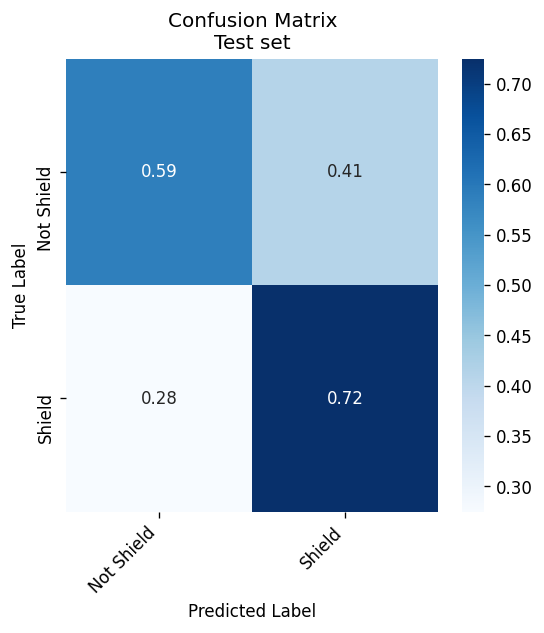

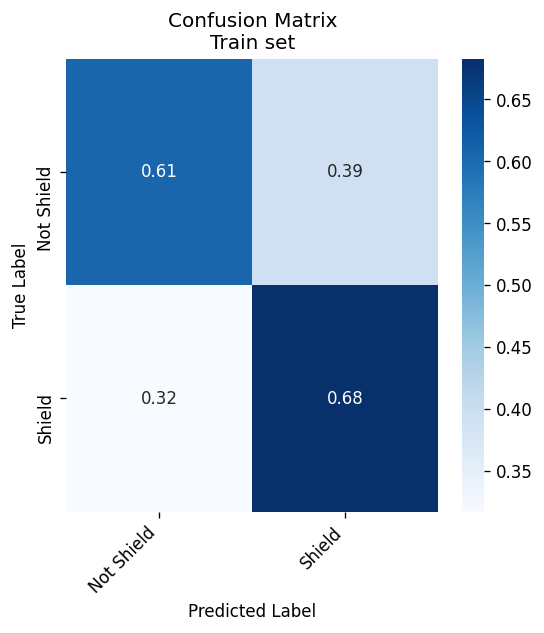

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=None,
                          title='Confusion Matrix', plot_numbers=False, display_names=None,
                          figsize=(15, 11)):

    cm = confusion_matrix(y_true, y_pred, labels=class_names, normalize=normalize)
    
    if not display_names:
        display_names = class_names
    df_cm = pd.DataFrame(cm, index=display_names, columns=display_names)
    fig = plt.figure(figsize=figsize, dpi=120)
    sns.heatmap(df_cm, annot=plot_numbers, cmap='Blues', fmt=".2")
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation=45)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    return fig

fig = plot_confusion_matrix(y_test, np.array(tf.nn.sigmoid(y_pred[2])).round(), class_names=[0, 1], display_names=['Not Shield', 'Shield'], normalize='true', figsize=(5,5), plot_numbers=True, title='Confusion Matrix\nTest set')
plt.show()
fig = plot_confusion_matrix(y_train, np.array(tf.nn.sigmoid(y_pred_train[2])).round(), class_names=[0, 1], display_names=['Not Shield', 'Shield'], normalize='true', figsize=(5,5), plot_numbers=True, title='Confusion Matrix\nTrain set')
plt.show()

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([352, 360]))

## Classifier Conclusion

We see that our model classification model achieves 64% and 65% accuracy on train and test sets correspondingly; given that we are working on a balanced setting, this results are positive. We can conclude that, even though the dataset size is limited, the model is able to detect shields patterns within an image and generalize it to further vases. This leads us to develop a segmentation model for detecting the position of a shield within a vase image.

# Image Masking

Since we got positive results from the classification task, we proceeded to develop an object segmentation model. We first had to build a segmentation dataset using the same tool as we did for labelling images (LabelBox). Given the time required to hand-make the masks and our uncertainty of how difficult the task was for the model, we decided to filter shields that were "easy" for detection. We selected half of the most promising vase images for mask making, with clear views of the shields and where the shields followed conventional shapes (very rounded or oval).

In [ ]:
# Setting up paths

root = '/content/drive/MyDrive/CS109b FP'
mask_dir = f'{root}/mask_images'
mask_vase_dir = f'{root}/mask_vase_images'
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
if not os.path.exists(mask_vase_dir):
    os.mkdir(mask_vase_dir)

In [ ]:
# Loading mask information made from Labelbox
with open(f'{root}/data/segmentation.json') as f:
    data = json.load(f)

In [ ]:
masks = [elem['Label']['objects'] for elem in data]
has_mask = [len(m)>0 for m in masks]

In [ ]:
# Saving masks
idx_mask = np.where(has_mask)[0]

for idx in tqdm(idx_mask):
    id_ = data[idx]['External ID'].split('_')[-1].rstrip('.jpeg')
    
    vase_path = f'{mask_vase_dir}/vase_{id_}.jpeg'
    vase_url = data[idx]['Labeled Data']    
    vase_img = Image.open(urlopen(vase_url))
    vase_img.save(vase_path)

    mask_path = f'{mask_dir}/mask_{id_}.jpeg'
    mask_url = data[idx]['Label']['objects'][0]['instanceURI']
    mask_img = Image.open(urlopen(mask_url))
    mask_i = np.array(mask_img).max(axis=-1)
    mask_i = Image.fromarray(mask_i)
    mask_i.save(mask_path)

# Segmentation Model

## Setting Up Data

In [3]:
# Setting up paths
root = '/content/drive/MyDrive/CS109b FP'
shields_dir = f'{root}/mask_vase_images'
masks_dir = f'{root}/mask_images'
seg_dir = f'{root}/data/segmentation'
meta_path = f'{root}/data/type_shields_metadata.csv'
model_path = f'{root}/data/segmentation/model.bin'

In [5]:
# Get available masks id
id_f = lambda x: int(x.split('_')[-1].rstrip('.jpeg'))

masks_files = os.listdir(masks_dir)
masks_image_ids = [id_f(name) for name in masks_files]

In [6]:
# Filter metadata of segmentation dataset (items with available masks)
meta = pd.read_csv(meta_path)
meta['image_id'] = meta.File.apply(id_f)
meta_seg = meta[meta.image_id.isin(masks_image_ids)].reset_index(drop=True)

In [7]:
# Retrieve shield and mask images
shield_img_all = []
mask_img_all = []

for i, item in tqdm(meta_seg.iterrows()):
  image_id = item.image_id
  shield_path = f'{shields_dir}/vase_{image_id}.jpeg'
  shield_img = np.array(Image.open(shield_path))
  shield_img_all.append(shield_img)

  mask_path = f'{masks_dir}/mask_{image_id}.jpeg'
  mask_img = np.array(Image.open(mask_path))
  mask_img_all.append(mask_img)

shield_img_all = np.array(shield_img_all)
mask_img_all = np.array(mask_img_all)

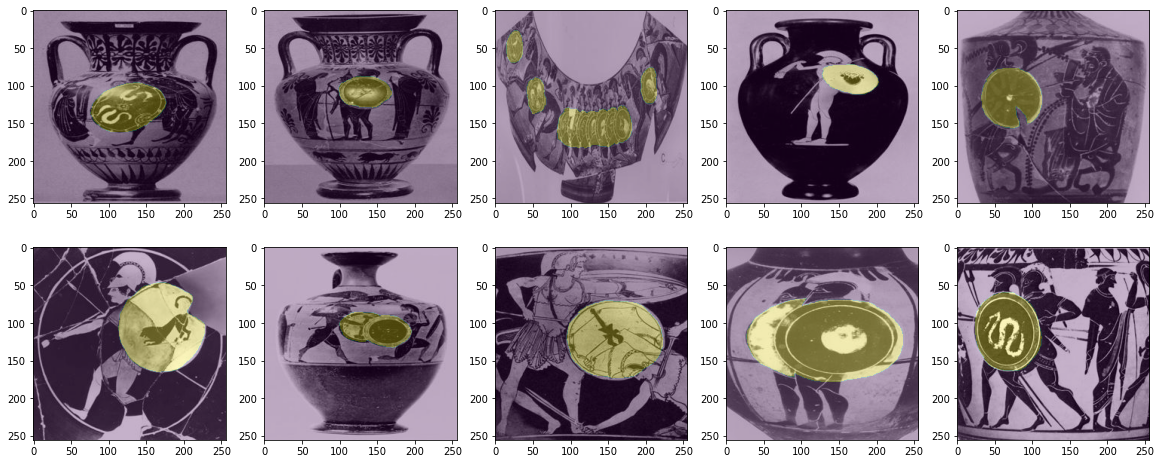

In [8]:
# Sample of mask

nrows = 2
ncols = 5
sample_size = nrows*ncols
sample_idx = np.random.choice(range(shield_img_all.shape[0]), size=sample_size)
sample_imgs = shield_img_all[sample_idx]
sample_masks = mask_img_all[sample_idx]

fig, axes = plt.subplots(nrows, ncols, figsize=(20,8))
axes = axes.flatten()
# for idx, axes_ in zip(sample_idx, axes):
for i in range(len(axes)):
  axes_ = axes[i]
  axes_.imshow(Image.fromarray(sample_imgs[i].reshape(256,256)).convert('RGB'))
  axes_.imshow(sample_masks[i].reshape(256,256), alpha=0.3)
plt.show()

In [9]:
# Format model inputs (shields) and labels (masks)
def format_shield(shield_data):
  orig_shape = shield_data.shape
  temp = shield_data.astype(np.int32).flatten()
  temp = temp/255
  shield_data = temp.reshape(orig_shape)
  shield_data = shield_data.reshape(-1,256,256,1)
  return shield_data

def format_mask(mask_data):
  orig_shape = mask_data.shape
  temp = mask_data.astype(np.float32).flatten()
  temp = np.clip(temp, 0 ,1)
  # temp[temp==0] = -1
  mask_data = temp.reshape(-1,256,256,1)
  return mask_data

shield_img_all_ = format_shield(shield_img_all)
mask_img_all_ = format_mask(mask_img_all)

In [10]:
shield_img_all_.shape, mask_img_all_.shape

((852, 256, 256, 1), (852, 256, 256, 1))

In [11]:
# Train, test, val splits by vase number

random_state = 23
meta_vases = meta_seg.drop_duplicates('Vase Number')['Vase Number'].values
train_vases, test_vases = train_test_split(meta_vases, test_size=0.1, random_state=random_state)
train_vases, val_cases = train_test_split(train_vases, test_size=0.1, random_state=random_state)

train_index = np.where(meta_seg['Vase Number'].isin(train_vases))[0]
test_index = np.where(meta_seg['Vase Number'].isin(test_vases))[0]
val_index = np.where(meta_seg['Vase Number'].isin(val_cases))[0]

X_train = shield_img_all_[train_index]
X_test = shield_img_all_[test_index]
X_val = shield_img_all_[val_index]

y_train = mask_img_all_[train_index]
y_test = mask_img_all_[test_index]
y_val = mask_img_all_[val_index]

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((693, 256, 256, 1),
 (77, 256, 256, 1),
 (82, 256, 256, 1),
 (693, 256, 256, 1),
 (77, 256, 256, 1),
 (82, 256, 256, 1))

In [ ]:
# Save data
save_data = {
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val
    }

for name, data in save_data.items(): 
  save_path = f'{seg_dir}/{name}.npy'
  with open(save_path, 'wb') as f:
      np.save(f, data)

## Model

In [ ]:
# Load data 

X_train = np.load(open(f'{seg_dir}/X_train.npy','rb'))
X_test = np.load(open(f'{seg_dir}/X_test.npy','rb'))
X_val = np.load(open(f'{seg_dir}/X_val.npy','rb'))

y_train = np.load(open(f'{seg_dir}/y_train.npy','rb'))
y_test = np.load(open(f'{seg_dir}/y_test.npy','rb'))
y_val = np.load(open(f'{seg_dir}/y_val.npy','rb'))

In [12]:
# Binary crossentropy loss that gives more weight to masked pixels
def masked_loss(y_true, y_pred):
    get_mult_mask = tf.cast(tf.greater_equal(y_true[:, :, :, 0], 1), dtype=tf.float32)*9
    raw_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    masked = get_mult_mask * raw_loss
    masked = raw_loss + masked
    return tf.reduce_mean(masked)

In [13]:
class ConvolutionBlock(keras.layers.Layer):

    def __init__(self, filters, name='ConvolutionalBlock', **kwargs):
        
        super(ConvolutionBlock, self).__init__(filters, name=name, **kwargs)
        self.conv = keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')
        self.norm = keras.layers.BatchNormalization()
        self.drop = keras.layers.Dropout(0.2)

    def call(self, inputs, training=None):
        x = self.conv(inputs)
        x = self.norm(x)
        z = self.drop(x)
        return z

In [14]:
# U-net inspired architecture

# Encoder
inputs = keras.layers.Input(shape=(256,256,1))
conv1 = ConvolutionBlock(32, name='conv1')(inputs)
conv2 = ConvolutionBlock(32, name='conv2')(conv1)
max1 = keras.layers.MaxPool2D()(conv2)
conv3 = ConvolutionBlock(32, name='conv3')(max1)
conv4 = ConvolutionBlock(64, name='conv4')(conv3)
max2= keras.layers.MaxPool2D()(conv4)
conv5 = ConvolutionBlock(64, name='conv5')(max2)
conv6 = ConvolutionBlock(64, name='conv6')(conv5)
max3= keras.layers.MaxPool2D()(conv6)
conv7 = ConvolutionBlock(64, name='conv7')(max3)
conv8 = ConvolutionBlock(64, name='conv8')(conv7)
max4= keras.layers.MaxPool2D()(conv8)
conv9 = ConvolutionBlock(64, name='conv9')(max4)
conv10 = ConvolutionBlock(64, name='conv10')(conv9)

# Decoder
up1 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv10), conv8], axis=-1)
conv11 = ConvolutionBlock(64, name='conv11')(up1)
conv12 = ConvolutionBlock(64, name='conv12')(conv11)
up2 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv12), conv6], axis=-1)
conv13 = ConvolutionBlock(64, name='conv13')(up2)
conv14 = ConvolutionBlock(64, name='conv14')(conv13)
up3 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv14), conv4], axis=-1)
conv15 = ConvolutionBlock(64, name='conv15')(up3)
conv16 = ConvolutionBlock(64, name='conv16')(conv15)
up4 = keras.layers.concatenate([keras.layers.UpSampling2D()(conv16), conv2], axis=-1)
conv17 = ConvolutionBlock(64, name='conv17')(up4)
conv18 = ConvolutionBlock(64, name='conv18')(conv17)
outputs = keras.layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(conv18)

seg_model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1 (ConvolutionBlock)        (None, 256, 256, 32) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2 (ConvolutionBlock)        (None, 256, 256, 32) 9376        conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2[0][0]                      
______________________________________________________________________________________________

In [ ]:
# Training model
BATCH_SIZE = 32
EPOCHS = 50

seg_model.compile(optimizer='adam',
                  loss=masked_loss)

seg_model_file = f'{model_dir}/model1'
mchk=tf.keras.callbacks.ModelCheckpoint(filepath=seg_model_file,  monitor="val_loss", verbose=1,
    save_best_only=True, save_weights_only=True, mode="auto", save_freq="epoch" )

history = seg_model.fit(X_train, y_train, 
                        epochs=EPOCHS, 
                        verbose=1,
                        validation_data=(X_val, y_val),
                        shuffle=True, 
                        batch_size=BATCH_SIZE,
                        callbacks=[mchk])

In [16]:
seg_model.load_weights('/content/drive/MyDrive/CS109b FP/segm/segm_weights')

In [35]:
X_train_pred = seg_model.predict(X_train)
X_test_pred = seg_model.predict(X_test)
X_val_pred = seg_model.predict(X_val)

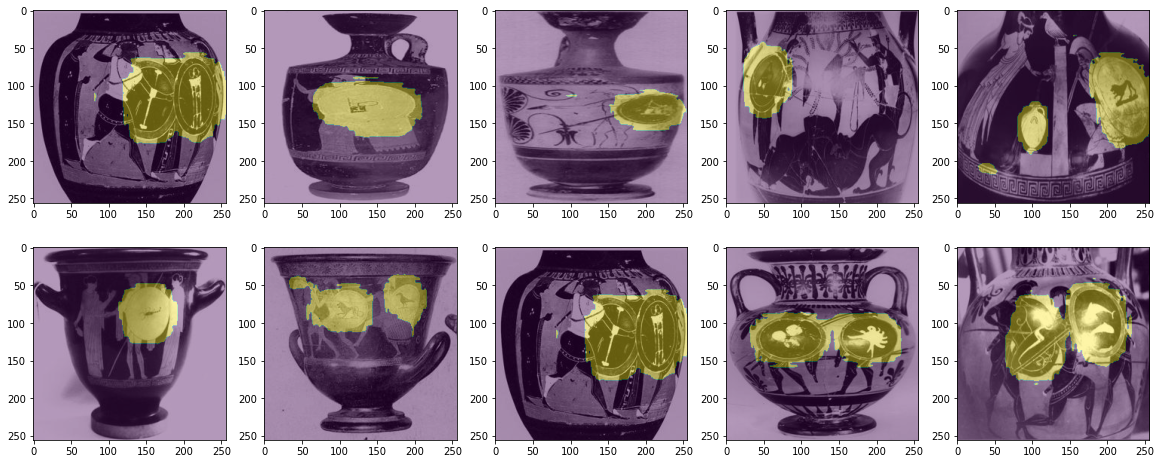

In [34]:
# Visualizing model prediction on validation set
nrows = 2
ncols = 5
sample_size = nrows*ncols
sample_idx = np.random.choice(range(X_val_pred.shape[0]), size=sample_size)
sample_imgs = X_val[sample_idx]
sample_pred = X_val_pred[sample_idx]

fig, axes = plt.subplots(nrows, ncols, figsize=(20,8))
axes = axes.flatten()
for i in range(len(axes)):
  axes_ = axes[i]
  axes_.imshow(sample_imgs[i].reshape(256,256), cmap='gray')
  axes_.imshow(sample_pred[i].round().reshape(256,256), alpha=0.4)
plt.show()

In [31]:
def get_DICE(y_true, y_pred):
  DICE = []
  for i in range(y_true.shape[0]):
    volume_sum = y_true[i].sum() + y_pred[i].sum()
    overlap = np.dot(y_true[i].flatten(), y_pred[i].flatten())
    DICE.append((2*overlap)/volume_sum)

  DICE = np.array(DICE)
  return DICE.mean()


In [33]:
get_DICE(y_test, X_test_pred)

0.712803467590065

In [37]:
get_DICE(y_train, X_train_pred)

0.6814532466341944

## Segmentation Conclusion

The resulting images on the validation set show that our model can detect the position of a shield within a vase image. It misses the exact shape, especially for paintings with thin strokes, which is not surprising. These results are promising and suggest that we could further improve our model if we increased our masking dataset. We conclude that classification and automatic model detection is feasible for greek vases images; this could be extended to other objects within greek vases.

# References

* [1] David A. Forsyth and Jean Ponce. 2002. Computer Vision: A Modern Approach. Prentice Hall Professional Technical Reference.
* [2] Minaee, S., Boykov, Y., Porikli, F., Plaza, A., Kehtarnavaz, N., and Terzopoulos, D. 2020. “Image Segmentation Using Deep Learning: A Survey”, arXiv e-prints.
* [3] Ronneberger, O., Fischer, P., and Brox, T. 2015. “U-Net: Convolutional Networks for Biomedical Image Segmentation”, arXiv e-prints.
* [4] Chen, L.-C., Papandreou, G., Kokkinos, I., Murphy, K., and Yuille, A. L. 2016. “DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs”, arXiv e-prints.
* [5] He, K., Gkioxari, G., Dollár, P., and Girshick, R. 2017. “Mask R-CNN”, arXiv e-prints.
* [6] S. Smirnov and A. Eguizabal, "Deep learning for object detection in fine-art paintings," 2018 Metrology for Archaeology and Cultural Heritage (MetroArchaeo), 2018, pp. 45-49, doi: 10.1109/MetroArchaeo43810.2018.9089828.
* [7] H. -J. Jeon, S. Jung, Y. -S. Choi, J. W. Kim and J. S. Kim, "Object Detection in Artworks Using Data Augmentation," 2020 International Conference on Information and Communication Technology Convergence (ICTC), 2020, pp. 1312-1314, doi: 10.1109/ICTC49870.2020.9289321.
* [8] Gonthier, N., Gousseau, Y., Ladjal, S., and Bonfait, O. 2018. “Weakly Supervised Object Detection in Artworks”, arXiv e-prints.
* [9] Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2012. "ImageNet classification with deep convolutional neural networks". In Proceedings of the 25th International Conference on Neural Information Processing Systems - Volume 1 (NIPS'12). Curran Associates Inc., Red Hook, NY, USA, 1097–1105.
* [10] Simonyan, K. and Zisserman, A. 2014. "Very Deep Convolutional Networks for Large-Scale Image Recognition", arXiv e-prints.
* [11] Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., and Wojna, Z. 2015. "Rethinking the Inception Architecture for Computer Vision", arXiv e-prints.
* [12] He, K., Zhang, X., Ren, S., and Sun, J. 2015. "Deep Residual Learning for Image Recognition", arXiv e-prints.
* [13] Howard, A. G. 2017. "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", arXiv e-prints.
